In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

# Data encoding

Data encoding is fundamental to quantum machine learning (QML) and to quantum computing in general, if we are to use quantum computers to solve real-world problems with real-world data. Initially, classical data has to be encoded or mapped to the quantum state of a dedicated quantum register. Once classical data is encoded and formatted as quantum data, a quantum algorithm can perform a computation on the data.

There are many different ways to encode classical data to a quantum state. In this notebook, we will cover a few of the most important encoding schemes in quantum computing and touch on their importance in QML.
Data encoding schemes involve encoding classical data features to quantum degrees of freedom, such as phase and amplitude. We present two main types of encoding schemes in this notebook. One is broadly termed *qubit encoding*, where $n$ features are encoded to the degrees of freedom of $n$ qubits, and the other type involves *feature encoding* to the degrees of freedom of $2^n$ computational basis states. The latter is much harder to do; the complexity is measured in an exponential number of CNOT gates with respect to the number of qubits.<sup>1</sup><sup>,</sup><sup>2</sup>

A data encoding scheme should be efficient to ensure it is tractable and to ensure the desired quantum speedup is maintained end-to-end throughout the computation. Efficient data loading remains one of the key challenges in our drive toward quantum advantage for many applications. In QML, *quantum feature maps* are a type of data encoding for mapping data to a rich feature space to improve predictive performance. The data encoding schemes in this notebook can be seen as building blocks for quantum feature maps, with particular attention to phase encoding in this course. To learn more, review the “Quantum feature map” notebook.

## Data preliminaries

### Notation

A data set is represented as a set of data vectors $\text{X} = \{\bar{x}_j\}$ or as a data matrix $\text{X}_{jk}$. A data vector has $N$ dimensions $\bar{x}\ = (x_1,\dots,x_N)$, where the dimensions have associated feature values $x_i$. The goal of data encoding can be seen as mapping a data vector to a quantum state vector $\bar{x} \rightarrow |\bar{x}\rangle$.

### Normalization and information loss

In classical machine learning, training data features are usually normalized or rescaled by using min-max normalization or standardization to improve model performance. In min-max normalization, feature columns of the data matrix $\text{X}$ are normalized $x'_k = (x_k - \text{min}(x_k))/(\text{max}(x_k)-\text{min}(x_k))$ so that all the feature values fall in the unit interval $x'_k \in [0,1]$. Once the training data features have been normalized, then these parameters need to be used to normalize the test data features as well, using the same normalization transformation to prevent information leakage. Information is leaked or lost when all features are forced to common scale and variance.

Normalization in quantum mechanics requires that the length, or norm, of a state vector $|\psi\rangle$ is equal to unity: $\|\psi\|=\sqrt{\langle\psi|\psi\rangle} = 1$, ensuring that measurement probabilities sum to 1. The state is normalized by dividing by the norm; that is, by rescaling $\|\psi\|^{-1}|\psi\rangle$. In practice, the data vector would be normalized first $\bar{x} \rightarrow \bar{x}'$ and then encoded to the quantum register $\bar{x}' \rightarrow |\bar{x}'\rangle$. Note that one way this is different from feature normalization used in classical machine learning is that the rescaling is applied to the vectors rather than the feature columns so that the lengths of all the data vectors are 1. Removing the relative vector length in this way is another cause of information loss between the data vectors.

In amplitude encoding, as we will see below, the data vector is normalized $\|\bar{x}\| = 1$ as is required by quantum mechanics. In phase encoding, feature values are recommended to be rescaled as $x_i \in (0,2\pi]$ so that there is no information loss due to the modulo-$2\pi$ effect of encoding to a qubit phase angle.<sup>3</sup><sup>, </sup><sup>4</sup> This $2\pi$ rescaling can be achieved with min-max feature normalization of $\text{X}$ to a range of $(0,2\pi]$, although this results in information loss, as described previously.

## Amplitude encoding

Amplitude encoding is widely used in QML. It can provide improved accuracy and more learnable input in hybrid quantum-classical neural networks.<sup>5</sup> However, amplitude encoding for QML kernel-based frameworks may be of limited benefit.<sup>6</sup>

In amplitude encoding, data features are encoded in the probability amplitudes associated with the computational basis states. Amplitude encoding is closely related to “wavefunction encoding.”

A general qubit state $|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$ has two probability amplitudes, $\alpha$ and $\beta$, that are normalized as $|\alpha|^2 + |\beta|^2 = 1$. After a data vector is normalized, the feature values, $x_i$, can be mapped to the probability amplitudes of a multi-qubit state,

\begin{equation}
|\bar{x}\rangle = \sum^N_{i=1} x_i|i\rangle,
\end{equation}

where $\{|i\rangle\}$ is the basis in decimal labeling $1,\dots,N$.

Example: The basis states for two qubits are $\{|00\rangle$,$|01\rangle$,$|10\rangle$,$|11\rangle\}$. We can encode the data vector $\bar{x} = (1, 2, 3, 4)$ with a length or norm $\|\bar{x}\| = \sqrt{1^2 + 2^2 + 3^2 + 4^2} = \sqrt{30}$. Therefore, the normalized data vector is $\bar{x} = \frac{1}{\sqrt{30}}(1, 2, 3, 4)$, which ensures that the data vector now has a length of 1. Performing amplitude encoding for this data vector to a 4-qubit register gives the normalized quantum state

\begin{equation}
|\bar{x}\rangle = \textstyle\frac{1}{\sqrt{30}}|00\rangle+\frac{2}{\sqrt{30}}|01\rangle+\frac{3}{\sqrt{30}}|10\rangle+\frac{4}{\sqrt{30}}|11\rangle.
\end{equation}

A benefit of amplitude encoding is that only $\log_2(N)$ qubits are required for an $N$-dimensional data vector $|\bar{x}\rangle$. However, amplitude encoding is generally an inefficient procedure that requires arbitrary state preparation, which is exponential in the number of CNOT gates, or equivalently stated has a polynomial runtime complexity of $\mathcal O(N)$ in the number of dimensions. Amplitude encoding “provides an exponential saving in space at the cost of an exponential increase in time”<sup>7</sup>; however, runtime increases to $\mathcal O(\log N)$ are achievable in certain cases.<sup>8</sup> For an end-to-end quantum speedup, the data loading runtime complexity needs to be considered.

We can implement amplitude encoding implicitly with Qiskit using the ```initialize``` method, as shown in the following code. This method performs arbitrary state preparation using the scheme in Shende, Bullock, and Markov 2006.<sup>1</sup>

In [2]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np
from math import sqrt

init_array = np.array([1,2,3,4])              # Unnormalized data vector
length = sqrt(sum([1**2, 2**2, 3**2, 4**2]))  # Vector length
norm_array = init_array/length                # Normalized array
print("Normalized array:")
print(norm_array)
print()

# Instantiate QuantumCircuit class with 2 qubits
qc = QuantumCircuit(2)             
# Initialize quantum circuit with norm_array
# This implicitly implements amplitude encoding
qc.initialize(norm_array, [0,1])   
print("Successfully initialized a quantum circuit with valid normalized array.\n")

# Instantiate Statevector object from QuantumCircuit instruction qc
state = Statevector.from_instruction(qc)
print("state is")
print(state)

Normalized array:
[0.18257419 0.36514837 0.54772256 0.73029674]

Successfully initialized a quantum circuit with valid normalized array.

state is
Statevector([0.18257419+0.j, 0.36514837+0.j, 0.54772256+0.j,
             0.73029674+0.j],
            dims=(2, 2))


Amplitude encoding can be used to encode not only a vector, but also other mathematical objects, such as matrices

\begin{equation}
|A\rangle = \sum^N_{r=1} \sum^M_{c=1} x_{r,c}|r\rangle|c\rangle
\end{equation}

where $r$ and $c$ are row and column indices, respectively.

## Phase encoding

The phase angle of a qubit is a real-valued angle $\theta$ about the Z-axis from the reference vector in the +X-axis direction. Data is mapped with a phase rotation, $\hat{P}(\theta) = e^{i\theta/2}\hat{R}_Z(\theta)$, where $\theta \in (0,2\pi]$ ([Qiskit PhaseGate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PhaseGate.html)). It is recommended to rescale data so that $x_i \in (0,2\pi]$. This prevents information loss and other potentially unwanted effects.<sup>3</sup><sup>,</sup><sup>4</sup>

A qubit is often initialized in the state $|0\rangle$, which is an eigenstate of the phase rotation operator, meaning that the qubit state first needs to be rotated for phase encoding to be implemented. It therefore makes sense to initialize the state with a Hadamard gate: $\hat{H}|0\rangle = |+\rangle = \textstyle\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$. Phase encoding on a single qubit means imparting a relative phase proportional to the data value:

\begin{equation}
|x\rangle = P(\theta=x)|+\rangle = \textstyle\frac{1}{\sqrt{2}}\big(|0\rangle + e^{ix}|1\rangle\big).
\end{equation}

The phase encoding procedure maps each feature value to the phase of a corresponding qubit, $x_i \rightarrow Q_i$. In total, phase encoding has a circuit depth of 2, including the Hadamard layer, which makes it an efficient encoding scheme. The phase-encoded multi-qubit state is a product state:

\begin{equation}
|\bar{x}\rangle = \bigotimes_{i=1}^n P_i(\theta=x_i)|+\rangle^{\otimes n} = {\textstyle\frac{1}{\sqrt{2^n}}} \bigotimes_{i=1}^n\big(|0\rangle + e^{ix_i}|1\rangle\big).
\end{equation}

The following Qiskit code first prepares the initial state of a single qubit by rotating it with a Hadamard gate, then rotates it again using a phase gate to encode a data value $x=\frac{1}{2}\pi$.

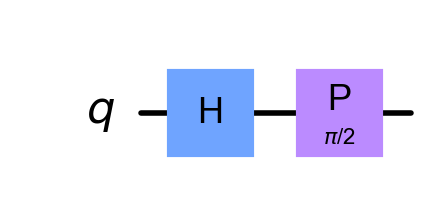

In [3]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from math import pi

qc = QuantumCircuit(1)
qc.h(0)         # Hadamard gate rotates state down to Bloch equator
state1 = Statevector.from_instruction(qc)

qc.p(pi/2, 0)   # Phase gate rotates by an angle pi/2
state2 = Statevector.from_instruction(qc)

states = state1, state2

qc.draw('mpl', scale=2)

Shown above is the single-qubit quantum circuit with a Hadamard gate and a phase gate. The evolution of the qubit state through the quantum circuit from ```state1``` to ```state2``` to phase encode a data value $x=\frac{1}{2}\pi$ is shown in the following code cell.

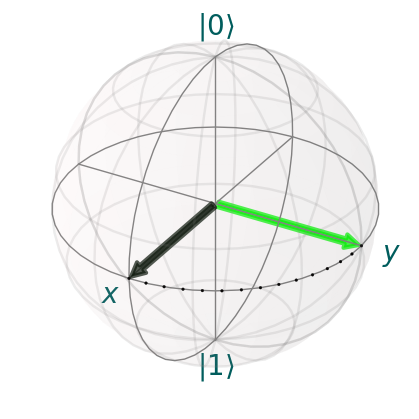

In [5]:
from qiskit.visualization.bloch import Bloch
from qiskit.visualization.state_visualization import _bloch_multivector_data
from math import sqrt
import numpy as np


def plot_Nstates(states, axis, plot_trace_points=True):
    """This function plots N states to 1 Bloch sphere"""
    bloch_vecs = [_bloch_multivector_data(s)[0] for s in states]

    if axis == None:
        bloch_plot = Bloch()
    else:
        bloch_plot = Bloch(axes=axis)
    
    bloch_plot.add_vectors(bloch_vecs)
    
    if len(states) > 1:
        
        def rgba_map(x, num):
            g = (0.95 - 0.05)/(num-1)
            i = 0.95 - g*num
            y = g*x + i
            return (0.0, y, 0.0, 0.7)
        
        num = len(states)
        bloch_plot.vector_color = [rgba_map(x, num) for x in range(1, num+1)]
    
    bloch_plot.vector_width = 3
    bloch_plot.vector_style = 'simple'

    if plot_trace_points:
        
        def trace_points(bloch_vec1, bloch_vec2):
            #bloch_vec = (x,y,z)
            n_points = 15
            thetas = np.arccos([bloch_vec1[2], bloch_vec2[2]])
            phis = np.arctan2([bloch_vec1[1], bloch_vec2[1]],
                              [bloch_vec1[0], bloch_vec2[0]])
            if phis[1] < 0:
                phis[1] = phis[1] + 2*pi
            angles0 = np.linspace(phis[0], phis[1], n_points)
            angles1 = np.linspace(thetas[0], thetas[1], n_points)

            xp = np.cos(angles0)*np.sin(angles1)
            yp = np.sin(angles0)*np.sin(angles1)
            zp = np.cos(angles1)
            pnts = [xp, yp, zp]
            bloch_plot.add_points(pnts)
            bloch_plot.point_color = 'k'
            bloch_plot.point_size = [4]*len(bloch_plot.points)
            bloch_plot.point_marker = ['o']

        for i in range(len(bloch_vecs)-1):
            trace_points(bloch_vecs[i], bloch_vecs[i+1])
    
    bloch_plot.sphere_alpha = 0.05
    bloch_plot.frame_alpha = 0.15
    bloch_plot.figsize = [4,4]

    bloch_plot.render()
    

plot_Nstates(states, axis=None, plot_trace_points=True)

The Bloch sphere plot shows the Z-axis rotation $|+\rangle \rightarrow P(\frac{1}{2}\pi)|+\rangle$ where $x=\frac{1}{2}\pi$. The light green arrow shows the final state.

Phase encoding is used in quantum feature maps, particularly $Z$ and $ZZ$ feature maps, general Pauli feature maps, and variational circuits.

## Angle encoding

Angle encoding is of interest in QML models using Pauli feature maps such as quantum support vector machines (QSVMs) and variational circuits such as VQC and quantum neural networks.

Angle encoding is similar to phase encoding, but instead of using a Z-axis rotation, either an X- or Y-axis rotation is used.<sup>3</sup><sup>,</sup><sup>7</sup> Y-axis rotation is more common in the literature, so we present it here.

For Y-axis rotation, data is mapped with a Y-axis rotation gate $R_Y(\theta)$ by a real-valued angle $\theta \in (0, 2\pi]$ ([Qiskit RYGate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RYGate.html)). As with phase encoding, we recommend that you rescale data so that $x_i \in (0,2\pi]$, preventing information loss and other unwanted effects.

When applied to a single qubit, angle encoding imparts a Y-axis rotation proportional to the data value:

\begin{equation}
|x\rangle = R_Y(\theta=x)|0\rangle = \textstyle\cos\left(\frac{x}{2}\right)|0\rangle + \sin\left(\frac{x}{2}\right)|1\rangle.
\end{equation}

Angle encoding rotates data from the initial state, $|0\rangle$, about the Y-axis toward the state $|1\rangle$, and changes the amplitudes of the basis states accordingly. Each feature value is mapped to a corresponding qubit, $x_i \rightarrow Q_i$, giving a product state. Angle encoding has a circuit depth of 1, which makes it an efficient encoding scheme. Y-axis angle encoding creates real-valued quantum states that can be useful for certain applications.

Alternatively, angle encoding can be performed using $R_X(\theta)$ gates, although the encoded state would have a complex relative phase compared to $R_Y(\theta)$.

The following Qiskit code rotates a single qubit from an initial state $|0\rangle$ to encode a data value $x=\frac{1}{2}\pi$.

In [6]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from math import pi

qc = QuantumCircuit(1)
state1 = Statevector.from_instruction(qc)
qc.ry(pi/2, 0)   # Phase gate rotates by an angle pi/2
state2 = Statevector.from_instruction(qc)
states = state1, state2

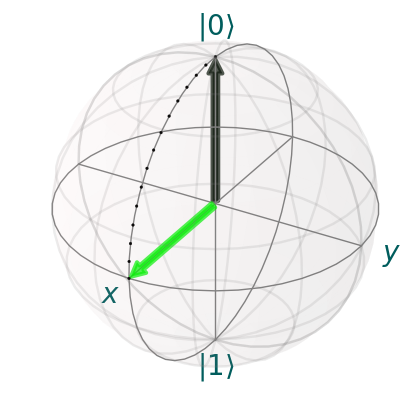

In [7]:
plot_Nstates(states, axis=None, plot_trace_points=True)

The Bloch sphere plot shows the Y-axis rotation $|0\rangle \rightarrow R_Y(\frac{1}{2}\pi)|0\rangle$. The light green arrow shows the final state.

## Dense angle encoding

Dense angle encoding (DAE) is a simple combination of angle encoding and phase encoding. It provides high accuracy with a quantum classifier and is partially robust to noise.<sup>7</sup>
DAE allows two feature values to be encoded in a single qubit: one angle with a Y-axis rotation angle, and the other with a Z-axis rotation angle: $x_1$, $x_2 \rightarrow \theta, \phi$. It encodes a 2D vector $\bar{x} = (x_1, x_2) $ as follows: 
 
\begin{equation}
|\bar{x}\rangle = R_Z(\phi=x_2) R_Y(\theta=x_1)|0\rangle = \cos\left(\frac{x_1}{2}\right)|0\rangle + e^{ix_2} \sin\left(\frac{x_1}{2}\right)|1\rangle.
\end{equation}

Encoding two data features to one qubit results in a $2\times$ reduction in the number of qubits required for the encoding.

DAE can be generalized to arbitrary functions of the two features instead of the sinusoidal functions used here. This is called general qubit encoding<sup>7</sup>, reflecting that the encoded state is a product state.

In [8]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from math import pi

qc = QuantumCircuit(1)
state1 = Statevector.from_instruction(qc)
qc.ry(3*pi/8, 0) 
state2 = Statevector.from_instruction(qc)
qc.rz(14*pi/8, 0)
state3 = Statevector.from_instruction(qc)
states = state1, state2, state3

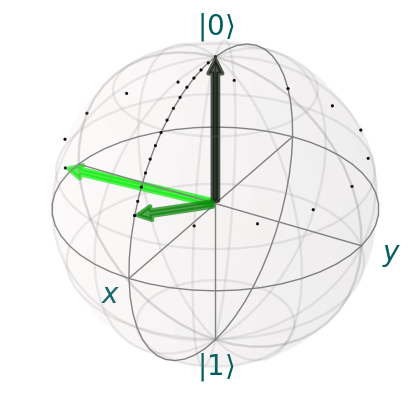

In [9]:
plot_Nstates(states, axis=None, plot_trace_points=True)

The Bloch sphere plot shows a Y-axis rotation and a second Z-axis rotation $|0\rangle \rightarrow R_Z \left( \frac{14}{8}\pi \right) R_Y \left( \frac{3}{8}\pi \right) |0\rangle$ to encode two feature values. The light green arrow shows the final state.

## Basis encoding

Basis encoding involves mapping a binary number to the computational basis states of a quantum register; it is efficient to implement. A typical data value in base 10, like a feature value, first needs to be binary-encoded in base 2. In basis encoding, the probability amplitude of each basis state is either 0 or 1 depending on the binary number being encoded. An integer feature value encoded in binary is a bitstring $b_N b_{N-1} \dots b_0$, where $b_j \in \{0,1\}$. Note that the most significant bit (MSB) is on the left and the least significant bit (LSB) is on the right. This bit string encodes to the basis state

\begin{equation}
|x\rangle = |b_N b_{N-1} \dots b_0\rangle
\end{equation}

with an amplitude of 1. Implicitly, all other basis state amplitudes are 0. Correspondingly, the most significant qubit is on the left and least significant is on the right. This is the standard ordering of binary numbers and the convention used in Qiskit. For example, the number 3 in 4-bit binary is 0011 and encodes to the basis state $|0011\rangle$. 

To encode many binary feature values of a data vector $x_i$, each value is encoded in an equal superposition of corresponding basis states in a set $S$. Basis encoding with superposition is a form of amplitude encoding.

\begin{equation}
|\bar{x}\rangle = \frac{1}{\sqrt{M}}\sum^M_{i \in S}|b_N b_{N-1} \dots b_0\rangle_i
\end{equation}

For example, the 4-bit binary integers 0011 and 0101 would be encoded to the quantum state $\frac{1}{\sqrt{2}}(|0011\rangle + |0101\rangle)$.

Many well-known binary encodings are used in quantum computing. An important signed integer encoding is two’s complement (used in Gilliam, Woerner, and Gonciulea 2021<sup>9</sup>). Non-integer encodings like fixed-point and floating-point may also be used. Encodings are associated with a level of precision. The desired encoding precision determines how many qubits are used to encode a number. The following formula gives the number of qubits needed, $m$, in the encoding register to achieve a level of precision, with $p$ bits of accuracy and an upper bound of the error $\epsilon$:<sup>3</sup><sup>,</sup><sup>10</sup>

\begin{equation}
m = p + \left \lceil \log_2\left(2 + \epsilon^{-1}\right) \right \rceil.
\end{equation}


Basis encoding is widely used in quantum computation, but there are theoretical reasons to believe that it may not be advantageous in some QML algorithms.<sup>6</sup>

## Qsample encoding

Qsample encoding aims to encode a discrete probability distribution $\{p_i\}$ to the probability amplitudes of the state of a quantum register using amplitude encoding (see previous section). The square root of the probabilities $\sqrt{p_i}$ are encoded in the basis state amplitudes:

\begin{equation}
|\psi_{p_i}\rangle = \sum^N_{i=1} \sqrt{p_i}|i\rangle.
\end{equation}

If measurements are performed directly on this state, the outcomes would be bit strings $i$ with probabilities $p_i$ determined by the probability amplitudes:

\begin{equation}
p_i = | \sqrt{p_i} |^2 = | \langle i|\psi_{p_i}\rangle |^2.
\end{equation}

For example, given a discrete probability distribution $\{p_i\} = \{p_1, p_2, p_3, p_3\}$, the square roots of the probabilities are precalculated classically and then qsample encoded, giving the state:

\begin{equation}
|\psi_{p_i}\rangle = \sqrt{p_1}|00\rangle + \sqrt{p_2}|01\rangle + \sqrt{p_3}|10\rangle + \sqrt{p_4}|11\rangle.
\end{equation}

It is possible to extend qsample encoding to joint probability distributions, marginal distributions, and to use rejection sampling.<sup>3</sup>

Often, a discrete probability distribution is created from a continous distribution. In this case, if the distribution is efficiently integrable, it can be prepared efficiently according to the Grover-Rudolph scheme.<sup>8</sup> Another possibility is to create it by using quantum random access memory (QRAM), as described in a later section.

Recent research<sup>11</sup> shows that if the aim is to perform quantum Monte Carlo (QMC) integration with $|\psi_{p_i}\rangle$ prepared using the Grover-Rudolph scheme, the desired quantum speedup is lost; however, an efficient state preparation scheme for QMC has been proposed.<sup>12</sup>

## Quantum random access memory

Quantum random access memory (QRAM) is an umbrella term for a number of schemes designed to efficiently access data held in memory and prepare arbitrary quantum states for quantum computation. The original bucket-brigade (BB) QRAM scheme proposed by Vittorio Giovannetti, Seth Lloyd, and Lorenzo Maccone<sup>13</sup> provides an exponential reduction in the number of switches $N$ required for a memory call, in $\mathcal O(\log N)$ instead of $\mathcal O(N)$ for classical RAM.

In general, QRAM can be used to access data stored in quantum or classical states, making it a data encoding scheme.<sup>14</sup> Memory cells are addressed in a superposition, which can be used to prepare encoded states that would otherwise be inefficient to prepare, like amplitude-encoded states. Due to large entangled states in the QRAM algorithm, experimental realizations are still in the early stages of development.
 
BB-QRAM yields an exponential speedup for pattern recognition, period finding, discrete logarithm, and quantum Fourier transform algorithms, and it is required for a number of other algorithms, including quantum search on a classical database, collision finding, and element distinctness; further, it enables new quantum primitives.<sup>13</sup>  A recent circuit-based QRAM for classical data has been proposed.<sup>15</sup>

## References

1. <a id='Shende2006'></a>Vivek V. Shende, Stephen S. Bullock, and Igor L. Markov. “Synthesis of Quantum Logic Circuits.” *IEEE Transactions on Computer-Adied Design*, vol. 25, no. 6 (2006): 1000–1010. https://arxiv.org/abs/quant-ph/0406176.

2. <a id='Plesch2011'></a>Martin Plesch and Časlav Brukner. “Quantum State Preparation with Universal Gate Decompositions.” *Physical Review A*, vol. 83 (2011): 32302. https://arxiv.org/abs/1003.5760.   

3. <a id='Schuld2018'></a>Maria Schuld and Francesco Petruccione. *Supervised Learning with Quantum Computers*. Waterloo, ON: Springer, 2018. https://www.springer.com/gp/book/9783319964232. 

4. <a id='Havlicek2018'></a>Vojtech Havlicek et al., “Supervised Learning with Quantum Enhanced Feature Spaces.” *Nature*, vol. 567 (2019): 209–212. https://arxiv.org/abs/1804.11326.

5. <a id='Sierra-Sosa2020'></a>Daniel Sierra-Sosa, Michael Telahun, and Adel Elmaghraby. “TensorFlow Quantum: Impacts of Quantum State Preparation on Quantum Machine Learning Performance.” *IEEE Access*, vol. 8 (2020): 215246–215255. https://ieeexplore.ieee.org/document/9272350.

6. <a id='Schuld2021'></a>Maria Schuld. “Supervised Quantum Machine Learning Models Are Kernel Methods.” arXiv:210.11020, last updated April 17, 2021. https://arxiv.org/abs/2101.11020. 

7. <a id='LaRose2020'></a>Ryan LaRose and Brian Coyle. “Robust Data Encodings for Quantum Classifiers.” *Physical Review A*, vol. 102 (2020): 32420. https://arxiv.org/abs/2003.01695.

8. <a id='Grover2002'></a>Lou Grover and Terry Rudolph. “Creating Superpositions That Correspond to Efficiently Integrable Probability Distributions.” arXiv:quant-ph/0208112, August 15, 2002, https://arxiv.org/abs/quant-ph/0208112.

9. <a id='Gilliam2021'></a>Austin Gilliam, Stefan Woerner, and Constantin Gonciulea, “Grover Adaptive Search for Constrained Polynomial Binary Optimization.” *Quantum*, vol. 5 (2021): 428. https://arxiv.org/abs/1912.04088.

10. <a id='Johnston2019'></a>Eric R. Johnston, Nic Harrigan, and Mercedes Gimeno-Segovia. *Programming Quantum Computers: Essential Algorithms and Code Samples.* Sebastopol, CA: O’Reilly, 2019. https://www.oreilly.com/library/view/programming-quantum-computers/9781492039679/.

11. <a id='Herbert2021'></a>Steven Herbert. “The Problem with Grover-Rudolph State Preparation for Quantum Monte-Carlo.” *Physical Review E*, vol. 103 (2021): 63302. https://arxiv.org/abs/2101.02240.

12. <a id='Vazquez2020'></a>Almudena Carrera Vazquez and Stefan Woerner. “Efficient State Preparation for Quantum Amplitude Estimation.” *Physical Review Applied*, vol. 15 (2021): 34027. https://arxiv.org/abs/2005.07711.

13. <a id='Giovannetti2008'></a>Vittorio Giovannetti, Seth Lloyd, and Lorenzo Maccone. “Quantum Random Access Memory.” *Physical Review Letters*, vol. 100 (2008): 160501. https://arxiv.org/abs/0708.1879.

14. <a id='Biamonte2018'></a>Jacob Biamonte et al. “Quantum Machine Learning.” *Nature*, vol. 549 (2017): 195–202. https://arxiv.org/abs/1611.09347.

15. <a id='Park2019'></a>Daniel K. Park, Francesco Petruccione, and June-Koo Kevin Rhee. “Circuit-Based Quantum Random Access Memory for Classical Data.” *Scientific Reports*, vol. 9 (2019). https://www.nature.com/articles/s41598-019-40439-3.


<span style="font-size:10pt; font-weight:bold;"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>